# IrisのデータをXGBoostで回帰分析

### 方針

- パッケージの読み込み
- データセットの読み込み
- クラス分類の時と変わってアヤメの種類をOne Hot表現にエンコードした。

- データセットを学習と評価用に分ける
- ハイパーパラメータ探索しつつ学習する
- 評価する（RMSE）
- 予測と実測の可視化
- 変数の重要度を可視化

In [1]:
import xgboost as xgb
from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, mean_squared_error
import sklearn.preprocessing as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# データセット読み込み

iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data)
iris_df = iris_df.rename(columns={
    0: 'sepal_length',
    1: 'sepal_width',
    2: 'petal_length',
    3: 'petal_width'})
iris_df['target'] = iris.target

# 数字のカテゴリをカテゴリ名に埋めなおしている
for i, name in enumerate(iris.target_names):
    iris_df['target'] = iris_df['target'].where(iris_df['target'] != i, name)
display(iris_df.head())

# ラベルエンコーダを使ってまた数字に戻している
le = sp.LabelEncoder()
le.fit(iris_df.target.unique())
iris_df.target = le.fit_transform(iris_df.target)
display(iris_df.head())

# OneHotEncoderでtargetを3つのクラスのOneHot表現に変更している
ohe = sp.OneHotEncoder()
enced = ohe.fit_transform(iris_df.target.values.reshape(1, -1).transpose())
temp = pd.DataFrame(index=iris_df.target.index, columns="target-" + le.classes_, data=enced.toarray())
iris_df = pd.concat([iris_df, temp], axis=1)
del iris_df['target']
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,sepal_length,sepal_width,petal_length,petal_width,target-setosa,target-versicolor,target-virginica
0,5.1,3.5,1.4,0.2,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,1.0,0.0,0.0


In [3]:
# データセットを学習と評価用に分ける

train_df, test_df = model_selection.train_test_split(iris_df, test_size=0.3)
train_df_y = train_df[['sepal_length']]
train_df_x = train_df.copy().drop('sepal_length', axis=1)
test_df_y = test_df[['sepal_length']]
test_df_x = test_df.copy().drop('sepal_length', axis=1)

In [4]:
# ハイパーパラメータ探索しつつ学習する

clf = xgb.XGBRegressor()

# ハイパーパラメータ探索
clf_cv = model_selection.GridSearchCV(clf, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
clf_cv.fit(train_df_x, [i[0] for i in train_df_y.values])
print('ベストパラメータ{}、そのスコア{:0.4f}'.format(clf_cv.best_params_, clf_cv.best_score_))


# 改めて最適パラメータで学習
clf = xgb.XGBRegressor(**clf_cv.best_params_)
clf.fit(train_df_x, [i[0] for i in train_df_y.values])

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
ベストパラメータ{'max_depth': 6, 'n_estimators': 50}、そのスコア0.7977


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.2s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [5]:
# 評価するRMSE(Root Mean Square Error) 平均二重誤差

mean_pred = [train_df_y.mean() for i in range(len(test_df_y))]
rmse_base = np.sqrt(mean_squared_error(test_df_y, mean_pred))
print("学習データの平均を予測としたやつをBaseLineとする\nBaseLineのrmse: " + str(rmse_base))

pred = clf.predict(test_df_x)
rmse = np.sqrt(mean_squared_error(test_df_y, pred))
print("予測したやつのrmse: " + str(rmse))


学習データの平均を予測としたやつをBaseLineとする
BaseLineのrmse: 0.8300579622595681
予測したやつのrmse: 0.31852210699452405


RMSEは一見良くなっているのかわからないので、ベースラインとして、学習データのSepal_lengthの平均値を予測とした場合のRMSEを先に表示した。
ちゃんと予測が機能していることがわかる（RMSEは値が小さいほど予実があっているということになる）

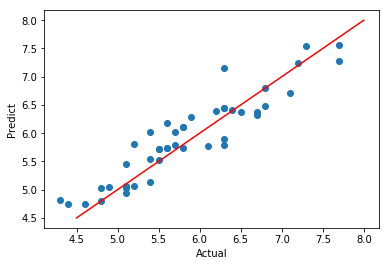

In [6]:
plt.ylabel("Predict")
plt.xlabel("Actual")
plt.scatter(test_df_y, pred)
plt.plot([4.5, 8], [4.5, 8], c='r')
plt.show()

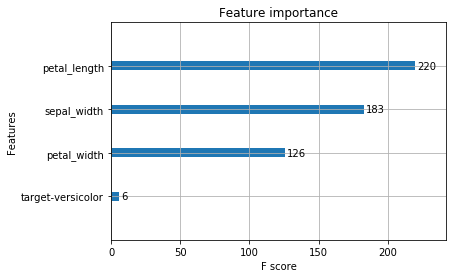

In [7]:
xgb.plot_importance(clf)
plt.show()